# Mapping sand in publicly available geospatial imagery using open-source image segmentation models 

An epub for the CSDMS 2023 annual meeting. This notebook is part of the [Doodleverse](https://github.com/Doodleverse), an ecosystem of software, data, and trained models for geoscientific image segmentation.

Authors:

* Daniel Buscombe, Marda Science$^1$
* Sharon Fitzpatrick$^1$
* Venus Ku$^1$
* Evan Goldstein$^2$

$^1$ Contracted to U.S. Geological Survey, Pacific Coastal and Marine Science Center

$^2$ Department of Geography, Environment, and Sustainability, University of North Carolina, Greensboro

![](https://user-images.githubusercontent.com/3596509/153729377-e16d0679-ca0d-4d0d-a9f9-90306ba2f871.png)

## Introduction

### Open source data, code, and trained ML models for image segmentation
The Doodleverse is a growing ecosystem of python codes, tensorflow models, and datasets in support of generic deep-learning-based semantic segmentation of geoscientific imagery. This epub demonstrates the functionality of image segmentation models for generic geoscientific tasks, available through [Segmentation Zoo](https://github.com/Doodleverse/segmentation_zoo), a collection of trained models for potentially broadly applicable image segmentation tasks. Many 'Zoo models (as they are affectionately known) are used in the [Seg2Map](https://github.com/Doodleverse/seg2map) application, which encodes a more sophisticated and broadly applicable workflow to image segmentation than this notebook represents.

### Mapping Sand
This notebook carries out the following tasks:

* Downloads a time-series of high-resolution orthomosaic imagery, using Google Earth Engine (GEE).
* Downloads a model for semantic segmentation of this imagery.
* Uses this model to identify sand pixels in this tiled imagery.
* Creates orthomosaic image labels by mosaicing model outputs.
* Carry out time-series analysis on outputs from multiple years.

This notebook represents a stripped-back, low-feature version of the [Seg2Map](https://github.com/Doodleverse/seg2map) toolbox. Using Seg2Map, it is possible to reproduce this analysis, i.e. using this model, and this location, as well as numerous additional image segmentation models, at any location inside the conterminuous United States. Here we use a model (Buscombe, 2023) trained using the Coast Train dataset described by Buscombe et al. (2023), made using Doodler, a Human-in-the-Loop image labeling program (Buscombe et al., 2021). More details about the dataset can be found on the [Coast Train website](https://coasttrain.github.io/CoastTrain/).

The model is called "orthoCT_8class_segformer_7641724", and is for the following classes: water, whitewater, sediment, other_bare_natural_terrain, marsh_vegetation, terrestrial_vegetation, agricultural, development. We'll be applying the model to imagery and using the outputs for the third class, "sediment". The model is a Segformer (Xie et al., 2021) model pre-trained on ImageNet, fine-tuned using labels , within the *Segmentation Gym* (Buscombe and Goldstein, 2022) software package. The SegFormer model architecture uses a hierarchical Transformer architecture, called "Mix Transformer", as an encoder, and a lightweight decoder for segmentation. It yields state-of-the-art performance on semantic segmentation while being more efficient than existing models.

HuggingFace 

Keras / Tensorflow

Imagery is from the National Agriculture Imagery Program (NAIP) .................

GEE API geemap package

GDAL for orthomosaic creation

### Scientific applications

Mapping sand allows for characterisation of the dynamics of natural sand landforms such as beaches and river mouths such as here, as well as deltas, estuaries, dunes, and perhaps any sandy deposit visible in 1m imagery.

Sand is a precious resource ... sand piracy.... etc


Imports

In [1]:
import geemap,ee 
import os, json , shutil
import numpy as np
from glob import glob
from shapely.geometry import LineString, MultiPolygon, Polygon
from shapely.ops import split
from osgeo import gdal
import requests

import rioxarray
import xarray as xr 
from datetime import datetime

from skimage.morphology import binary_erosion
from skimage.morphology import binary_opening
from skimage.morphology import disk 

ML imports

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from doodleverse_utils.prediction_imports import *

Version:  2.12.0
Eager mode:  True


In [3]:
from transformers import TFSegformerForSemanticSegmentation
from doodleverse_utils.model_imports import segformer

## Dataset retrieval

Note that this is a bare-bones version of what the Seg2Map application does a lot better.

In [4]:
###=================================================
############### USER INPUTS #########################
###=================================================
#output raster spatial footprint in meters
# recent NAIP imagery comes at 0.5m. Older imagery is natively 1m and gets upsampled
OUT_RES_M = 0.5 

# number of columns and rows to split
# this is for situations where the ROI is larger than GEE will allow in a single download
## so, we split the ROI into nx by ny regions
# in our case, we can use 2 x 2 regions
nx, ny = 2,2 

#name of the site (name it anything you like)
site = 'beaches'

#name of file containing 
roifile = 'ROI.geojson'

## years of data collection (list of strings)
years = ['2005','2010','2014','2016','2018','2020']

gee_collection = 'USDA/NAIP/DOQQ'

You only have to download and tile imagery once, so if you're running through this notebook for a second time and already have tiled imagery, you could set both of these flags to "False"

In [5]:
download_data = retile_data = True
# download_data = retile_data = False

if download_data:
    # initialize Earth Engine
    # ee.Authenticate()
    ee.Initialize()

Note, this requires a Google account to access imagery (for free).

1. Sign up to use Google Earth Engine Python API. First, you need to request access to Google Earth Engine at https://signup.earthengine.google.com/. It takes about 1 day for Google to approve requests.

2. Authenticate with earthengine. Once your request has been approved, with the conda environment activated, run the following command on the terminal to link your environment to the GEE server:
    
    `earthengine authenticate`
    
A web browser will open, login with a gmail account and accept the terms and conditions. Then copy the authorization code into the Anaconda terminal. In the latest version of the earthengine-api, the authentication is done with `gcloud`. If an error is raised about `gcloud` missing, go to https://cloud.google.com/sdk/docs/install and install `gcloud`. After you have installed it, close the terminal and restart it, then activate the environment before running earthengine authenticate again.    

### Download imagery

#### Part 1: use GEE to access image tiles

In [6]:
if download_data:

    ## open geojson file and load into a variable
    with open(roifile) as f:
        json_data = json.load(f)

    features = json_data['features']
    
    for year in years:

        start_date = year+'-01-01'
        end_date = year+'-12-31'

        try:
            os.mkdir(site)
        except:
            pass

        try:
            os.mkdir(site+os.sep+year)
        except:
            pass

        coordinates = features[0]['geometry']['coordinates'][0]
        collection = ee.ImageCollection(gee_collection)
        polygon = Polygon([tuple(c) for c in coordinates])

        minx, miny, maxx, maxy = polygon.bounds

        dx = (maxx - minx) / nx  # width of a small part
        dy = (maxy - miny) / ny  # height of a small part
        horizontal_splitters = [LineString([(minx, miny + i*dy), (maxx, miny + i*dy)]) for i in range(ny)]
        vertical_splitters = [LineString([(minx + i*dx, miny), (minx + i*dx, maxy)]) for i in range(nx)]
        splitters = horizontal_splitters + vertical_splitters

        result = polygon
        for splitter in splitters:
            result = MultiPolygon(split(result, splitter))
        parts = [list(part.exterior.coords) for part in result.geoms]

        counter = 1
        for part in parts:
            try:
                os.mkdir(site+os.sep+year+os.sep+'chunk'+str(counter))
            except:
                pass

            collection = ee.ImageCollection(gee_collection)

            polys = ee.Geometry.Polygon(part)

            centroid = polys.centroid()

            collection = collection.filterBounds(polys)
            collection = collection.filterDate(start_date, end_date).sort('system:time_start', True)
            count = collection.size().getInfo()
            img_lst = collection.toList(1000)

            N = []
            for i in range(0, count):
                image = ee.Image(img_lst.get(i))
                name = image.get('system:index').getInfo()
                N.append(name)

            for n in N:
                image = ee.Image('USDA/NAIP/DOQQ/'+n)
                geemap.ee_export_image(image, 
                                os.getcwd()+os.sep+site+os.sep+year+os.sep+'chunk'+str(counter)+os.sep+'chunk'+str(counter)+'_'+n+'_multiband.tif', 
                                scale=OUT_RES_M, region=polys, file_per_band=False, crs="EPSG:4326")

            counter += 1

Generating URL ...
Please wait ...
Data downloaded to /media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/2005/chunk1/chunk1_n_3612208_ne_10_1_20050613_multiband.tif
Generating URL ...
Please wait ...
Data downloaded to /media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/2005/chunk2/chunk2_n_3612101_nw_10_1_20050613_multiband.tif
Generating URL ...
Please wait ...
Data downloaded to /media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/2005/chunk2/chunk2_n_3612208_ne_10_1_20050613_multiband.tif
Generating URL ...
Please wait ...
Data downloaded to /media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/2005/chunk3/chunk3_n_3612208_ne_10_1_20050613_multiband.tif
Generating URL ...
Please wait ...
Data downloaded to /media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/2005/chunk4/chunk4_n_3612101_nw_10_1_20050613_multiband.tif
Generating URL ...
Please wait ...
Data 

#### Part 2: Organize files

copy files into a single directory per year

In [7]:
if download_data:
    for year in years:
        # move multiband files into own directory
        outdirec = os.getcwd()+os.sep+site+os.sep+year+os.sep+'multiband'
        try:
            os.mkdir( outdirec)
        except:
            pass

        # copy each multiband image to the multiband folder for that year
        for folder in glob( os.getcwd()+os.sep+site+os.sep+year+os.sep+'chunk*', recursive=True ):
            files = glob(folder+os.sep+'*multiband.tif')
            [shutil.copyfile(file,outdirec+os.sep+file.split(os.sep)[-1]) for file in files]
            
        ## delete 'chunk' folders - they are no longer necessary
        for folder in glob( os.getcwd()+os.sep+site+os.sep+year+os.sep+'chunk*', recursive=True ):
            shutil.rmtree(folder)            

#### Part 3: Make merged orthomosaics

Use gdal functions to mosaic the imagery back together, from 4 chunks per year, into one seamless image per year

In [11]:
if download_data:
    for year in years:

        for folder in glob( os.getcwd()+os.sep+site+os.sep+year+os.sep+'multiband', recursive=True ):
            print(folder)

            # ## run gdal to merge into big tiff 
            vrtoptions = gdal.BuildVRTOptions(resampleAlg='average', srcNodata=0, VRTNodata=0)
            files = glob(folder+os.sep+'*multiband.tif')
            print(len(files))
            outfile = os.getcwd()+os.sep+site+os.sep+f'merged_multispectral{year}.vrt'
            ds = gdal.BuildVRT(outfile, files, options=vrtoptions)
            # ds.FlushCache()
            ds = None

            # create geotiff
            ds = gdal.Translate(outfile.replace('.vrt','.tif'), creationOptions=["COMPRESS=LZW", "TILED=YES"], srcDS=outfile)
            ds = None   

            # create jpeg and world file
            ds = gdal.Translate(outfile.replace('.vrt','.jpg'), creationOptions=["WORLDFILE=YES", "QUALITY=100"], srcDS=outfile.replace('.vrt','.tif'))
            ds = None   


/media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/2005/multiband
6
/media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/2010/multiband
6


Warning 1: /media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/2010/multiband/chunk1_m_3612208_ne_10_1_20100529_multiband.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: /media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/2010/multiband/chunk4_m_3612101_nw_10_1_20100529_multiband.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: /media/marda/TWOTB/USGS/Doodl

/media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/2014/multiband
6


Warning 1: /media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/2014/multiband/chunk2_m_3612101_nw_10_1_20140613_multiband.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: /media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/2014/multiband/chunk4_m_3612208_ne_10_1_20140613_multiband.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: /media/marda/TWOTB/USGS/Doodl

/media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/2016/multiband
4


Warning 1: /media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/2016/multiband/chunk1_m_3612208_ne_10_h_20160619_multiband.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: /media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/2016/multiband/chunk3_m_3612208_ne_10_h_20160619_multiband.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: /media/marda/TWOTB/USGS/Doodl

/media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/2018/multiband
4


Warning 1: /media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/2018/multiband/chunk1_m_3612208_ne_10_060_20180725_20190209_multiband.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: /media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/2018/multiband/chunk4_m_3612208_ne_10_060_20180725_20190209_multiband.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: /media/

/media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/2020/multiband
6


Warning 1: /media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/2020/multiband/chunk2_m_3612208_ne_10_060_20200527_multiband.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: /media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/2020/multiband/chunk2_m_3612101_nw_10_060_20200527_multiband.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: /media/marda/TWOTB/USGS/D

## Retile imagery

Next, we want to chop all of our images up into tiles, with overlap

The model will be pointed to each image tile, resulting in a label tile

The overlap is to oversample the imagery; by overlapping the imagery by 50% in two dimensions, the model provides predictions up to 4 times for every pixel

We mosaic the overlapping label tiles back together afterwards, to make a label map

#### Part 1: define some variables

In [12]:
###### user variables
####========================
resampleAlg = 'mode' # alternatives = # 'nearest', 'max', 'min', 'average', 'gauss'
TARGET_SIZE = 768

OVERLAP_PX = TARGET_SIZE//2
print("Overlap size : {} px".format(OVERLAP_PX))

Overlap size : 384 px


Let's get a list of our image orthos and print them to screen

In [13]:
image_orthos = glob(os.getcwd()+os.sep+site+os.sep+'*.tif')
print(image_orthos)

['/media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/merged_multispectral2005.tif', '/media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/merged_multispectral2010.tif', '/media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/merged_multispectral2016.tif', '/media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/merged_multispectral2020.tif', '/media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/merged_multispectral2014.tif', '/media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/merged_multispectral2018.tif']


#### Part 2: tile imagery with overlap

Below we define a function to convert a geotiff to a jpeg, with some input arguments (we want only the first 3 bands, and want "byte" output format)

In [14]:
def gdal_translate_jpeg(f, bandList, kwargs):
    """downloads best model from zenodo.

    Args:
        files (list): list of available files for zenodo release
        model_direc (str): directory of model to download

    Raises:
        FileNotFoundError: if model filename in 'BEST_MODEL.txt' does not
        exist online
    """    
    ds = gdal.Translate(f.replace('.tif','.jpg'), f, bandList=bandList, **kwargs)
    ds = None # close and save ds

### convert to jpegs for Zoo model
kwargs = {
    'format': 'JPEG',
    'outputType': gdal.GDT_Byte
}

bandList=[1,2,3]            

In [15]:
if retile_data:
    for year in years:
        image_ortho = [i for i in image_orthos if year in i][0]
        print(image_ortho)

        indir = os.path.dirname(image_ortho)
        outdir = indir+os.sep+'tiles'+str(year)

        try:
            os.mkdir(outdir)
        except:
            pass

        if os.name == "nt": ## true if windows

            try:
                cmd = 'python gdal_retile.py -r near -ot Byte -ps {} {} -overlap {} -co "tiled=YES" -targetDir {} {}'.format(TARGET_SIZE,TARGET_SIZE,OVERLAP_PX,outdir,image_ortho)
                os.system(cmd)
            except:

                from subprocess import Popen, PIPE

                process=Popen(["python","C:\\OSGeo4W64\\bin\\gdal_retile.py","-r", "near", "-ot", "Byte","-ps",str(TARGET_SIZE),str(TARGET_SIZE),"-overlap",str(OVERLAP_PX),"-co", "tiled=YES","-targetDir",outdir, image_ortho], stdout=PIPE, stderr=PIPE)
                stdout, stderr = process.communicate()

        else: # true if linux/mac
            try:
                ## it would be cleaner if the gdal_retile.py script could be wrapped in gdal/osgeo python, but it errored for me ...
                cmd = 'gdal_retile.py -r near -ot Byte -ps {} {} -overlap {} -co "tiled=YES" -targetDir {} {}'.format(TARGET_SIZE,TARGET_SIZE,OVERLAP_PX,outdir,image_ortho)
                os.system(cmd)
            except:
                cmd = 'python gdal_retile.py -r near -ot Byte -ps {} {} -overlap {} -co "tiled=YES" -targetDir {} {}'.format(TARGET_SIZE,TARGET_SIZE,OVERLAP_PX,outdir,image_ortho)
                os.system(cmd)

        ## get a list of the tif files
        files_to_convert = glob(outdir+os.sep+'*.tif')
        ## cycle through each tif image to convert to jpeg
        for f in files_to_convert:
            gdal_translate_jpeg(f, bandList, kwargs)

        ## delete tif files
        _ = [os.remove(k) for k in glob(outdir+os.sep+'*.tif')]        

/media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/merged_multispectral2005.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
/media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/merged_multispectral2010.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
/media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/merged_multispectral2014.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
/media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/merged_multispectral2016.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
/media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/merged_multispectral2018.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
/media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/merged_multispectral2020.tif
0...10...20...30...40...50...60...70...80...90...100 

## Download and prep model

Segmentation Zoo models live on Zenodo. Models are published as a set of files. Often, zenodo releases contain several sets of trained models, and are used in ensemble. Each set includes an 'h5' format file that contains model weights (trained), and a 'json' format file that contains metadata. Both are needed to make predictions

The following are a set of functions that download the 'best' model. For this simple demo, we are using just one model, but several models are also often used together (or 'ensembled') to make more stable predictions.

In [17]:
def get_url_dict_to_download(models_json_dict: dict) -> dict:
    """Returns dictionary which contains
    paths to save downloaded files to matched with urls to download files

    each key in returned dictionary contains a full path to a file
    each value in returned dictionary contains url to download file
    ex.
    {'C:\Home\Project\file.json':"https://website/file.json"}

    Args:
        models_json_dict (dict): full path to files and links

    Returns:
        dict: full path to files and links
    """
    url_dict = {}
    for save_path, link in models_json_dict.items():
        if not os.path.isfile(save_path):
            url_dict[save_path] = link
        json_filepath = save_path.replace("_fullmodel.h5", ".json")
        if not os.path.isfile(json_filepath):
            json_link = link.replace("_fullmodel.h5", ".json")
            url_dict[json_filepath] = json_link

    return url_dict

def download_url(url, save_path, chunk_size=128):
    """downloads best model from zenodo.

    Args:
        files (list): list of available files for zenodo release
        model_direc (str): directory of model to download

    Raises:
        FileNotFoundError: if model filename in 'BEST_MODEL.txt' does not
        exist online
    """
    r = requests.get(url, stream=True)
    with open(save_path, "wb") as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

def download_BEST_model(files: list, model_direc: str) -> None:
    """downloads best model from zenodo.

    Args:
        files (list): list of available files for zenodo release
        model_direc (str): directory of model to download

    Raises:
        FileNotFoundError: if model filename in 'BEST_MODEL.txt' does not
        exist online
    """
    # dictionary to hold urls and full path to save models at
    models_json_dict = {}
    # retrieve best model text file
    best_model_json = [f for f in files if f["key"].strip() == "BEST_MODEL.txt"][0]
    best_model_txt_path = os.path.join(model_direc, "BEST_MODEL.txt")
    # if BEST_MODEL.txt file not exist download it
    if not os.path.isfile(best_model_txt_path):
        download_url(
            best_model_json["links"]["self"],
            best_model_txt_path,
        )

    # read in BEST_MODEL.txt file
    with open(best_model_txt_path) as f:
        best_model_filename = f.read().strip()

    print(f"Best Model filename: {best_model_filename}")
    # check if json and h5 file in BEST_MODEL.txt exist
    model_json = [f for f in files if f["key"].strip() == best_model_filename]
    if model_json == []:
        FILE_NOT_ONLINE_ERROR = f"File {best_model_filename} not found online. Raise an issue on Github"
        raise FileNotFoundError(FILE_NOT_ONLINE_ERROR)
    # path to save model
    outfile = os.path.join(model_direc, best_model_filename)
    # path to save file and json data associated with file saved to dict
    models_json_dict[outfile] = model_json[0]["links"]["self"]
    url_dict = get_url_dict_to_download(models_json_dict)
    # if any files are not found locally download them asynchronous
    if url_dict != {}:
        for save_path, url in url_dict.items():
            download_url(url, save_path)

In [18]:
def get_weights_list(model_choice: str, weights_direc: str) -> list:
    """Returns of list of full paths to weights files(.h5) within weights_direc

    Args:
        model_choice (str): 'ENSEMBLE' or 'BEST'
        weights_direc (str): full path to directory containing model weights

    Returns:
        list: list of full paths to weights files(.h5) within weights_direc
    """
    if model_choice == "ENSEMBLE":
        return glob(weights_direc + os.sep + "*.h5")
    elif model_choice == "BEST":
        with open(weights_direc + os.sep + "BEST_MODEL.txt") as f:
            w = f.readlines()
        return [weights_direc + os.sep + w[0]]

def get_config(weights_list: list) -> dict:
    """loads contents of config json files
    that have same name of h5 files in weights_list

    Args:
        weights_list (list): weight files(.h5) in weights_list

    Returns:
        dict: contents of config json files that have same name of h5 files in weights_list
    """
    weights_file = weights_list[0]
    configfile = weights_file.replace(".h5", ".json").replace("weights", "config").strip()
    if "fullmodel" in configfile:
        configfile = configfile.replace("_fullmodel", "").strip()
    with open(configfile.strip()) as f:
        config = json.load(f)
    return config

def request_available_files(zenodo_id: str) -> list:
    """returns list of available downloadable files for zenodo_id

    Args:
        zenodo_id (str): id of zenodo release

    Returns:
        list: list of available files downloadable for zenodo_id
    """
    # Send request to zenodo for selected model by zenodo_id
    root_url = "https://zenodo.org/api/records/" + zenodo_id
    r = requests.get(root_url)
    # get list of all files associated with zenodo id
    js = json.loads(r.text)
    files = js["files"]
    return files

def get_model_dir(parent_directory: str, dir_name: str) -> str:
    """returns full path to directory named dir_name and if it doesn't exist
    creates new directory dir_name within parent directory

    Args:
        parent_directory (str): directory to create new directory dir_name within
        dir_name (str): name of directory to get full path to

    Returns:
        str: full path to dir_name directory
    """
    new_dir = os.path.join(parent_directory, dir_name)
    if not os.path.isdir(new_dir):
        print(f"Creating {new_dir}")
        os.mkdir(new_dir)
    return new_dir

#### Part 1: define some variables

This is the name of the model we wish to use, based on the 8-class Coast Train dataset

In [19]:
###### user variables
####========================
variable = "orthoCT_8class_segformer_7641724"

model_choice = 'BEST'
print("Model implementation choice : {}".format(model_choice))

zenodo_id = variable.split("_")[-1]
print("Zenodo ID : {}".format(zenodo_id))

Model implementation choice : BEST
Zenodo ID : 7641724


#### Part 2: download and prep the model

Here is where we use all the above functions to find and download the correct files

In [20]:
# segmentation zoo directory
parent_direc = os.path.dirname(os.getcwd())

# create downloaded models directory in segmentation_zoo/downloaded_models
downloaded_models_dir = get_models_dir = get_model_dir(parent_direc, "downloaded_models")
print(f"Downloaded Models Located at: {downloaded_models_dir}")

# directory to hold specific downloaded model
model_direc = get_model_dir(downloaded_models_dir, variable)

# get list of available files to download for zenodo id
files = request_available_files(zenodo_id)

# download the model files
download_BEST_model(files, model_direc)

Downloaded Models Located at: /media/marda/TWOTB/USGS/Doodleverse/github/downloaded_models
Best Model filename: ct_NAIP_8class_768_segformer_v3_fullmodel.h5


Here is the model weights file. It's a single file in a list, because these codes could be adapted (indeed, have been adapted elsewhere in the Doodleverse) to ingest several trained model weights and use them in ensemble prediction mode

In [21]:
# get and show the location of the downloaded weights file
weights_files = get_weights_list(model_choice, model_direc)
print(weights_files)

['/media/marda/TWOTB/USGS/Doodleverse/github/downloaded_models/orthoCT_8class_segformer_7641724/ct_NAIP_8class_768_segformer_v3_fullmodel.h5']


Next, we define some functions that will help us apply the model and keep track of what we did (inside a dictionary called `metadatadict`)

In [22]:
def get_metadatadict(weights_list: list, config_files: list, model_names: list) -> dict:
    """returns dictionary of model weights,config_files, and model_names

    Args:
        weights_list (list): list of full paths to weights files(.h5)
        config_files (list): list of full paths to config files(.json)
        model_names (list): list of model names

    Returns:
        dict: dictionary of model weights,config_files, and model_names
    """
    metadatadict = {}
    metadatadict["model_weights"] = weights_list
    metadatadict["config_files"] = config_files
    metadatadict["model_names"] = model_names
    return metadatadict

def get_model(weights_list: list):
    """Loads models in from weights list and loads in corresponding config file
    for each model weights file(.h5) in weights_list

    Args:
        weights_list (list): full path to model weights files(.h5)

    Raises:
        Exception: raised if weights_list is empty
        Exception: An unknown model type was loaded from any of weights files in
        weights_list

    Returns:
       model, model_list, config_files, model_names
    """
    model_list = []
    config_files = []
    model_names = []
    if weights_list == []:
        raise Exception("No Model Info Passed")
        
    for weights in weights_list:
        # "fullmodel" is for serving on zoo they are smaller and more portable between systems than traditional h5 files
        # gym makes a h5 file, then you use gym to make a "fullmodel" version then zoo can read "fullmodel" version
        configfile = weights.replace(".h5", ".json").replace("weights", "config").strip()
        if "fullmodel" in configfile:
            configfile = configfile.replace("_fullmodel", "").strip()
        with open(configfile) as f:
            config = json.load(f)
        TARGET_SIZE = config.get("TARGET_SIZE")
        MODEL = config.get("MODEL")
        NCLASSES = config.get("NCLASSES")
        N_DATA_BANDS = config.get("N_DATA_BANDS")

        try:
            # Get the selected model based on the weights file's MODEL key provided
            # create the model with the data loaded in from the weights file
            # Load in the model from the weights which is the location of the weights file
            model = tf.keras.models.load_model(weights)
        except BaseException:
            id2label = {}
            for k in range(NCLASSES):
                id2label[k]=str(k)
            model = segformer(id2label,num_classes=NCLASSES)

            weights=weights.strip()
            model.load_weights(weights)

        model_names.append(MODEL)
        model_list.append(model)
        config_files.append(configfile)
    return model, model_list, config_files, model_names

#### Part 3: reconstruct the model for use

Now, we can make the model by reading in the config file, crerating the model architecture, then assigning our previously learned weights to the model

In [23]:
weights = weights_files[0]

configfile = weights.replace("_fullmodel.h5", ".json")
with open(configfile) as file:
    config = json.load(file)

for k in config.keys():
    exec(k + '=config["' + k + '"]')

model, model_list, config_files, model_names = get_model(weights_files)

Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Model application



#### Part 1: define some functions



In [31]:
def est_label_multiclass(image,model):
    """does this:
    Args:
        TARGET_SIZE (tuple):imagery will be resized to this size
        N_DATA_BANDS (int): number of bands in imagery
        NCLASSES (int): number of classes used in segmentation model
        sample_direc (str): full path to directory containing imagery to segment
        model_list (list): list of loaded models
        metadatadict (dict): config files, model weight files, and names of each model in model_list
    """
    est_label = model(tf.expand_dims(image, 0)).logits
    return est_label

# =========================================================
def do_seg(
    f, model, metadatadict, MODEL, sample_direc, 
    NCLASSES, N_DATA_BANDS, TARGET_SIZE,
    out_dir_name='out'
):
    """does this:
    Args:
        TARGET_SIZE (tuple):imagery will be resized to this size
        N_DATA_BANDS (int): number of bands in imagery
        NCLASSES (int): number of classes used in segmentation model
        sample_direc (str): full path to directory containing imagery to segment
        model_list (list): list of loaded models
        metadatadict (dict): config files, model weight files, and names of each model in model_list
    """

    if f.endswith("jpg"):
        segfile = f.replace(".jpg", "_predseg.png")
    elif f.endswith("png"):
        segfile = f.replace(".png", "_predseg.png")
    elif f.endswith("npz"):  
        segfile = f.replace(".npz", "_predseg.png")

    metadatadict["input_file"] = f
        
    # directory to hold the outputs of the models is named 'out' by default
    # create a directory to hold the outputs of the models, by default name it 'out' or the model name if it exists in metadatadict
    out_dir_path = os.path.normpath(sample_direc + os.sep + out_dir_name)
    if not os.path.exists(out_dir_path):
        os.mkdir(out_dir_path)

    segfile = os.path.normpath(segfile)
    segfile = segfile.replace(
        os.path.normpath(sample_direc), os.path.normpath(sample_direc + os.sep + out_dir_name)
    )

    metadatadict["nclasses"] = NCLASSES
    metadatadict["n_data_bands"] = N_DATA_BANDS

    ## read image from file
    image, w, h, bigimage = get_image(f,N_DATA_BANDS,TARGET_SIZE,MODEL)

    if np.std(image)==0:

        print("Image {} is empty".format(f))
        est_label = np.zeros((w,h))

    else:

        est_label = est_label_multiclass(image,model)
        # est_label cannot be float16 so convert to float32
        est_label = est_label.numpy().astype('float32')

        est_label = resize(est_label, (1, NCLASSES, TARGET_SIZE[0],TARGET_SIZE[1]), preserve_range=True, clip=True).squeeze()
        est_label = np.transpose(est_label, (1,2,0))
        est_label = resize(est_label, (w, h))

    metadatadict["av_prob_stack"] = est_label

    softmax_scores = est_label.copy() #np.dstack((e0,e1))

    metadatadict["av_softmax_scores"] = softmax_scores

    if np.std(image)>0:
        est_label = np.argmax(softmax_scores, -1)
    else:
        est_label = est_label.astype('uint8')

    class_label_colormap = [
        "#3366CC",
        "#DC3912",
        "#FF9900",
        "#109618",
        "#990099",
        "#0099C6",
        "#DD4477",
        "#66AA00",
        "#B82E2E",
        "#316395",
        "#ffe4e1",
        "#ff7373",
        "#666666",
        "#c0c0c0",
        "#66cdaa",
        "#afeeee",
        "#0e2f44",
        "#420420",
        "#794044",
        "#3399ff",
    ]

    class_label_colormap = class_label_colormap[:NCLASSES]

    metadatadict["color_segmentation_output"] = segfile

    color_label = label_to_colors(
        est_label,
        bigimage[:, :, 0] == 0,
        alpha=128,
        colormap=class_label_colormap,
        color_class_offset=0,
        do_alpha=False,
    )   

    imsave(segfile, (color_label).astype(np.uint8), check_contrast=False)
    
    metadatadict["color_segmentation_output"] = segfile

    segfile = segfile.replace("_predseg.png", "_res.npz")

    metadatadict["grey_label"] = est_label
    np.savez_compressed(segfile, **metadatadict)

    #### plot overlay
    segfile = segfile.replace("_res.npz", "_overlay.png")

    if N_DATA_BANDS <= 3:
        plt.imshow(bigimage, cmap='gray')
    else:
        plt.imshow(bigimage[:, :, :3])

    plt.imshow(color_label, alpha=0.5)
    plt.axis("off")
    plt.savefig(segfile, dpi=200, bbox_inches="tight")
    plt.close("all")

    #### image - overlay side by side
    segfile = segfile.replace("_res.npz", "_image_overlay.png")

    plt.subplot(121)
    if N_DATA_BANDS <= 3:
        plt.imshow(bigimage, cmap='gray')
    else:
        plt.imshow(bigimage[:, :, :3])
    plt.axis("off")

    plt.subplot(122)
    if N_DATA_BANDS <= 3:
        plt.imshow(bigimage, cmap='gray')
    else:
        plt.imshow(bigimage[:, :, :3])
    plt.imshow(color_label, alpha=0.5)
    plt.axis("off")
    plt.savefig(segfile, dpi=200, bbox_inches="tight")
    plt.close("all")
    

def compute_segmentation(
    TARGET_SIZE: tuple,
    N_DATA_BANDS: int,
    NCLASSES: int,
    MODEL,
    sample_direc: str,
    model_list: list,
    metadatadict: dict,
    do_parallel: bool
) -> None:
    """applies models in model_list to directory of imagery in sample_direc.
    imagery will be resized to TARGET_SIZE and should contain number of bands specified by
    N_DATA_BANDS. The outputted segmentation will contain number of classes corresponding to NCLASSES.
    Outputted segmented images will be located in a new subdirectory named 'out' created within sample_direc.
    Args:
        TARGET_SIZE (tuple):imagery will be resized to this size
        N_DATA_BANDS (int): number of bands in imagery
        NCLASSES (int): number of classes used in segmentation model
        sample_direc (str): full path to directory containing imagery to segment
        model_list (list): list of loaded models
        metadatadict (dict): config files, model weight files, and names of each model in model_list
    """

    # Read in the image filenames as either .npz,.jpg, or .png
    files_to_segment = sort_files(sample_direc)
    sample_direc=os.path.abspath(sample_direc)
    # Compute the segmentation for each of the files

    for file_to_seg in files_to_segment:
        do_seg(
            file_to_seg,
            model_list,
            metadatadict,
            MODEL,
            sample_direc=sample_direc,
            NCLASSES=NCLASSES,
            N_DATA_BANDS=N_DATA_BANDS,
            TARGET_SIZE=TARGET_SIZE)    

Utility functions that find and clean and move files:

In [32]:
def sort_files(sample_direc: str) -> list:
    """returns list of sorted filenames in sample_direc

    Args:
        sample_direc (str): full path to directory of imagery/npz
        to run models on

    Returns:
        list: list of sorted filenames in sample_direc
    """
    # prepares data to be predicted
    sample_filenames = sorted(glob(sample_direc + os.sep + "*.*"))

    if sample_filenames[0].split(".")[-1] == "npz":
        sample_filenames = sorted(tf.io.gfile.glob(sample_direc + os.sep + "*.npz"))
    else:
        sample_filenames = sorted(tf.io.gfile.glob(sample_direc + os.sep + "*.jpg"))
        if len(sample_filenames) == 0:
            sample_filenames = sorted(glob(sample_direc + os.sep + "*.png"))
    return sample_filenames

def clean_pngs(outdir):
    """does this:
    Args:
        TARGET_SIZE (tuple):imagery will be resized to this size
        N_DATA_BANDS (int): number of bands in imagery
        NCLASSES (int): number of classes used in segmentation model
        sample_direc (str): full path to directory containing imagery to segment
        model_list (list): list of loaded models
        metadatadict (dict): config files, model weight files, and names of each model in model_list
    """
    # "prob.png" files ...
    _ = [os.remove(k) for k in glob(outdir+os.sep+'out'+os.sep+'*prob.png')]

    # "overlay.png" files ...
    _ = [os.remove(k) for k in glob(outdir+os.sep+'out'+os.sep+'*overlay.png')]


def label_ortho_prep(outdir):
    """does this:
    Args:
        TARGET_SIZE (tuple):imagery will be resized to this size
        N_DATA_BANDS (int): number of bands in imagery
        NCLASSES (int): number of classes used in segmentation model
        sample_direc (str): full path to directory containing imagery to segment
        model_list (list): list of loaded models
        metadatadict (dict): config files, model weight files, and names of each model in model_list
    """    
    ### the trick here is to make asure all the png files and xml files are
    ### in the same directoy and have the same filename root

    # Get imgs list
    imgsToMosaic = sorted(glob(os.path.join(outdir, 'out', '*.png')))

    ## copy the xml files into the 'out' folder
    xml_files = sorted(glob(os.path.join(outdir, '*.xml')))

    for k in xml_files:
        shutil.copyfile(k,k.replace(outdir,outdir+os.sep+'out'))

    ## rename pngs
    for k in imgsToMosaic:
        os.rename(k,k.replace('_predseg',''))

    xml_files = sorted(glob(os.path.join(outdir,'out', '*.xml')))
    ## rename xmls
    for k in xml_files:
        os.rename(k, k.replace('.jpg.aux.xml', '.png.aux.xml'))  

Functions that call GDAL to carry out image mosaicing:

In [33]:
def mosaic_ortho_label(indir, outdir, year, resampleAlg):
    """does this:
    Args:
        TARGET_SIZE (tuple):imagery will be resized to this size
        N_DATA_BANDS (int): number of bands in imagery
        NCLASSES (int): number of classes used in segmentation model
        sample_direc (str): full path to directory containing imagery to segment
        model_list (list): list of loaded models
        metadatadict (dict): config files, model weight files, and names of each model in model_list
    """
    # make some output paths
    outVRTrgb = os.path.join(indir, f'MosaicRGB{year}.vrt')
    outTIFrgb = os.path.join(indir, f'MosaicRGB{year}.tif')

    ## now we have pngs and png.xml files with the same names in the same folder
    imgsToMosaic = sorted(glob(os.path.join(outdir, 'out', '*.png')))

    # First build vrt for geotiff output
    vrt_options = gdal.BuildVRTOptions(resampleAlg=resampleAlg, srcNodata=0, VRTNodata=0)
    ds = gdal.BuildVRT(outVRTrgb, imgsToMosaic, options=vrt_options)
    ds.FlushCache()
    ds = None

    # then build tiff
    ds = gdal.Translate(destName=outTIFrgb, creationOptions=["NUM_THREADS=ALL_CPUS", "COMPRESS=LZW", "TILED=YES"], srcDS=outVRTrgb)
    ds.FlushCache()
    ds = None

def mosaic_ortho_greylabel(outdir, year, resampleAlg):
    """does this:
    Args:
        TARGET_SIZE (tuple):imagery will be resized to this size
        N_DATA_BANDS (int): number of bands in imagery
        NCLASSES (int): number of classes used in segmentation model
        sample_direc (str): full path to directory containing imagery to segment
        model_list (list): list of loaded models
        metadatadict (dict): config files, model weight files, and names of each model in model_list
    """
    npzs = sorted(glob(os.path.join(outdir, 'out', '*.npz')))

    for k in npzs:
        write_greylabel_to_png(k)

    ## now we have pngs and png.xml files with the same names in the same folder
    imgsToMosaic = sorted(glob(os.path.join(outdir, 'out', '*res.png')))

    outVRT = os.path.join(indir, f'Mosaic{year}.vrt')
    outTIF = os.path.join(indir, f'Mosaic{year}.tif')
    
    xml_files = sorted(glob(os.path.join(outdir,'out', '*.xml')))
    ## copy and name xmls
    for k in xml_files:
        shutil.copyfile(k,k.replace('.png','_res.png'))

    # First build vrt for geotiff output
    vrt_options = gdal.BuildVRTOptions(resampleAlg=resampleAlg, srcNodata=0, VRTNodata=0)
    ds = gdal.BuildVRT(outVRT, imgsToMosaic, options=vrt_options)
    ds.FlushCache()
    ds = None

    # then build tiff
    ds = gdal.Translate(destName=outTIF, creationOptions=["NUM_THREADS=ALL_CPUS", "COMPRESS=LZW", "TILED=YES"], srcDS=outVRT)
    ds.FlushCache()
    ds = None        


def mosaic_ortho_greyprobs(outdir, indir, year):
    """does this:
    Args:
        TARGET_SIZE (tuple):imagery will be resized to this size
        N_DATA_BANDS (int): number of bands in imagery
        NCLASSES (int): number of classes used in segmentation model
        sample_direc (str): full path to directory containing imagery to segment
        model_list (list): list of loaded models
        metadatadict (dict): config files, model weight files, and names of each model in model_list
    """    
    npzs = sorted(glob(os.path.join(outdir,'out', '*res.npz')))
    for k in npzs:
        dat = write_greyprobs_to_tif(k)

    xml_files = sorted(glob(os.path.join(outdir,'out', '*res*.xml')))
    ## copy and name xmls
    for i in range(dat.shape[-1]):
        for k in xml_files:
            shutil.copyfile(k,k.replace('_res.png','_prob'+str(i)+'.tif'))

    if np.ndim(dat)==2:
        NCLASSES=1
    else:
        NCLASSES = dat.shape[-1]

    for i in range(NCLASSES):
        outVRT = os.path.join(indir, f'Mosaic{year}_Prob'+str(i)+'.vrt')
        outTIF = os.path.join(indir, f'Mosaic{year}_Prob'+str(i)+'.tif')

        ## now we have pngs and png.xml files with the same names in the same folder
        imgsToMosaic = sorted(glob(os.path.join(outdir, 'out', '*prob'+str(i)+'.tif')))

        # First build vrt for geotiff output
        vrt_options = gdal.BuildVRTOptions(resampleAlg="lanczos",srcNodata=0, VRTNodata=0)
        ds = gdal.BuildVRT(outVRT, imgsToMosaic, options=vrt_options)
        ds.FlushCache()
        ds = None

        # then build tiff
        ds = gdal.Translate(destName=outTIF, creationOptions=["NUM_THREADS=ALL_CPUS", "COMPRESS=LZW", "TILED=YES"], srcDS=outVRT)
        ds.FlushCache()
        ds = None     

In [34]:
def write_greyprobs_to_tif(k):
    """does this:
    Args:
        TARGET_SIZE (tuple):imagery will be resized to this size
        N_DATA_BANDS (int): number of bands in imagery
        NCLASSES (int): number of classes used in segmentation model
        sample_direc (str): full path to directory containing imagery to segment
        model_list (list): list of loaded models
        metadatadict (dict): config files, model weight files, and names of each model in model_list
    """    
    with np.load(k) as data:
        dat = tf.nn.softmax(data['av_softmax_scores']).numpy().astype('float32')
    if np.ndim(dat)==2:
        NCLASSES=1
    else:
        NCLASSES = dat.shape[-1]
    for i in range(NCLASSES):
        if NCLASSES>1:
            imsave(k.replace('res.npz','prob'+str(i)+'.tif'), dat[:,:,i], check_contrast=False, compression=0)
        else:
            imsave(k.replace('res.npz','prob'+str(i)+'.tif'), dat, check_contrast=False, compression=0)

    return dat

def write_greylabel_to_png(k):
    """does this:
    Args:
        TARGET_SIZE (tuple):imagery will be resized to this size
        N_DATA_BANDS (int): number of bands in imagery
        NCLASSES (int): number of classes used in segmentation model
        sample_direc (str): full path to directory containing imagery to segment
        model_list (list): list of loaded models
        metadatadict (dict): config files, model weight files, and names of each model in model_list
    """    
    with np.load(k) as data:
        dat = 1+np.round(data['grey_label'].astype('uint8'))
    imsave(k.replace('.npz','.png'), dat, check_contrast=False, compression=0)

In [35]:
# get dictionary containing all files needed to run models on data
metadatadict = get_metadatadict(weights_files, config_files, model_names)

# read contents of config file into dictionary
config = get_config(weights_files)
TARGET_SIZE = config.get("TARGET_SIZE")
NCLASSES = config.get("NCLASSES")
N_DATA_BANDS = config.get("N_DATA_BANDS")

#### Part 2: apply model to each image, and mosaic outputs

In [ ]:
for year in years:

    #####################################
    # STEP 1: define inputs and outputs   
    image_ortho = [i for i in image_orthos if year in i][0]
    print(image_ortho)
    indir = os.path.dirname(image_ortho)
    outdir = indir+os.sep+'tiles'+str(year)    
    sample_direc = outdir    

    #####################################
    # STEP 2: read images
    sample_filenames = sort_files(sample_direc)
    print("Number of samples: %i" % (len(sample_filenames)))            
    
    #####################################
    # STEP 3: apply model
    compute_segmentation(
        TARGET_SIZE,
        N_DATA_BANDS,
        NCLASSES,
        MODEL,
        sample_direc,
        model_list[0],
        metadatadict,
        False)
    
    #################################
    #### STEP 4: STITCH ORTHO LABEL TILES

    ## now, you have the 'out' folder ...
    # the out folder may contain a bunch of crap we dont want. let's delete those files
    # this should do nothing if mode='meta' or mode='minimal'
    clean_pngs(outdir)

    ##############################################
    ################ LABEL ORTHO CREATION PREP
    label_ortho_prep(outdir)

    ###############################################
    ################# LABEL ORTHO CREATION 
    ### let's stitch the label "predseg" pngs!
    mosaic_ortho_label(indir, outdir, year, resampleAlg)
            
    ##################################
    ##### STEP 5: MAKE AND STITCH ORTHO GREYSCALE LABEL TILES
    mosaic_ortho_greylabel(outdir, year, resampleAlg)

    ##################################
    ##### STEP 6: MAKE AND STITCH ORTHO GREYSCALE probability TILES
    mosaic_ortho_greyprobs(outdir, indir, year)
   

/media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/merged_multispectral2005.tif
Number of samples: 52
/media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/merged_multispectral2010.tif
Number of samples: 52
/media/marda/TWOTB/USGS/Doodleverse/github/MappingSand_CSDMS2023_epub/beaches/merged_multispectral2014.tif
Number of samples: 52


## Mapping Sand

The commented code below may be uncommented to use a small Dask cluster to carry out these analyses. Dask and xarray work well together, allowing you to perform computations that you wouldn't ordinarily have computing resources to successfully perform.

In [ ]:
# from dask.distributed import Client

# n_workers = 8
# threads_per_worker = 2
# memory_limit='10GB'

# ## start client
# client = Client(n_workers=n_workers, threads_per_worker=threads_per_worker, memory_limit=memory_limit)

#### Part 1: define some variables

In [ ]:
#############################################################
#################### user inputs 

dtype = 'float64'
chunksize = ("auto", "auto")

In [ ]:
mosaic_files = [f'{site}/Mosaic{year}.tif' for year in years]
mosaic_files = sorted(mosaic_files)
print(mosaic_files)

image_files = [f'{site}/merged_multispectral{year}.tif' for year in years]
image_files = sorted(image_files)
print(image_files)

# Create variable used for time axis
time_var = xr.Variable('time',years)
print(time_var)

#### Part 2: load geotiffs into xarray

In [79]:
# Load in and concatenate all individual GeoTIFFs
geotiffs_da = xr.concat([rioxarray.open_rasterio(i, chunks=chunksize, dtype=dtype) for i in mosaic_files],
                        dim=time_var)
# Covert our xarray.DataArray into a xarray.Dataset
geotiffs_ds = geotiffs_da.to_dataset('band')

# Rename the variable to a more useful name
geotiffs_ds = geotiffs_ds.rename({1: 'label'})

geotiffs_ds

<xarray.Dataset>
Dimensions:      (time: 6, y: 1635, x: 5165)
Coordinates:
  * x            (x) float64 -122.0 -122.0 -122.0 ... -122.0 -122.0 -122.0
  * y            (y) float64 36.97 36.97 36.97 36.97 ... 36.96 36.96 36.96 36.96
    spatial_ref  int64 0
  * time         (time) <U4 '2005' '2010' '2014' '2016' '2018' '2020'
Data variables:
    label        (time, y, x) uint8 dask.array<chunksize=(1, 1635, 5165), meta=np.ndarray>
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

In [80]:
# Load in and concatenate all individual GeoTIFFs
im_geotiffs_da = xr.concat([rioxarray.open_rasterio(i, chunks=chunksize, dtype=dtype) for i in image_files],
                        dim=time_var)
# Covert our xarray.DataArray into a xarray.Dataset
im_geotiffs_ds = im_geotiffs_da.to_dataset('band')

# Rename the variable to a more useful name
im_geotiffs_ds = im_geotiffs_ds.rename({1: 'red'})
im_geotiffs_ds = im_geotiffs_ds.rename({2: 'green'})
im_geotiffs_ds = im_geotiffs_ds.rename({3: 'blue'})
im_geotiffs_ds = im_geotiffs_ds.drop_vars(4)

im_geotiffs_ds

<xarray.Dataset>
Dimensions:      (time: 6, y: 1635, x: 5165)
Coordinates:
  * x            (x) float64 -122.0 -122.0 -122.0 ... -122.0 -122.0 -122.0
  * y            (y) float64 36.97 36.97 36.97 36.97 ... 36.96 36.96 36.96 36.96
    spatial_ref  int64 0
  * time         (time) <U4 '2005' '2010' '2014' '2016' '2018' '2020'
Data variables:
    red          (time, y, x) float64 dask.array<chunksize=(1, 1635, 5165), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(1, 1635, 5165), meta=np.ndarray>
    blue         (time, y, x) float64 dask.array<chunksize=(1, 1635, 5165), meta=np.ndarray>
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

#### Part 3: show model outputs

In [53]:
im_show = xr.concat([im_geotiffs_ds['red'],im_geotiffs_ds['green'],im_geotiffs_ds['blue']],dim=('x','x','x'))

Text(0.5, 1.0, '2020')

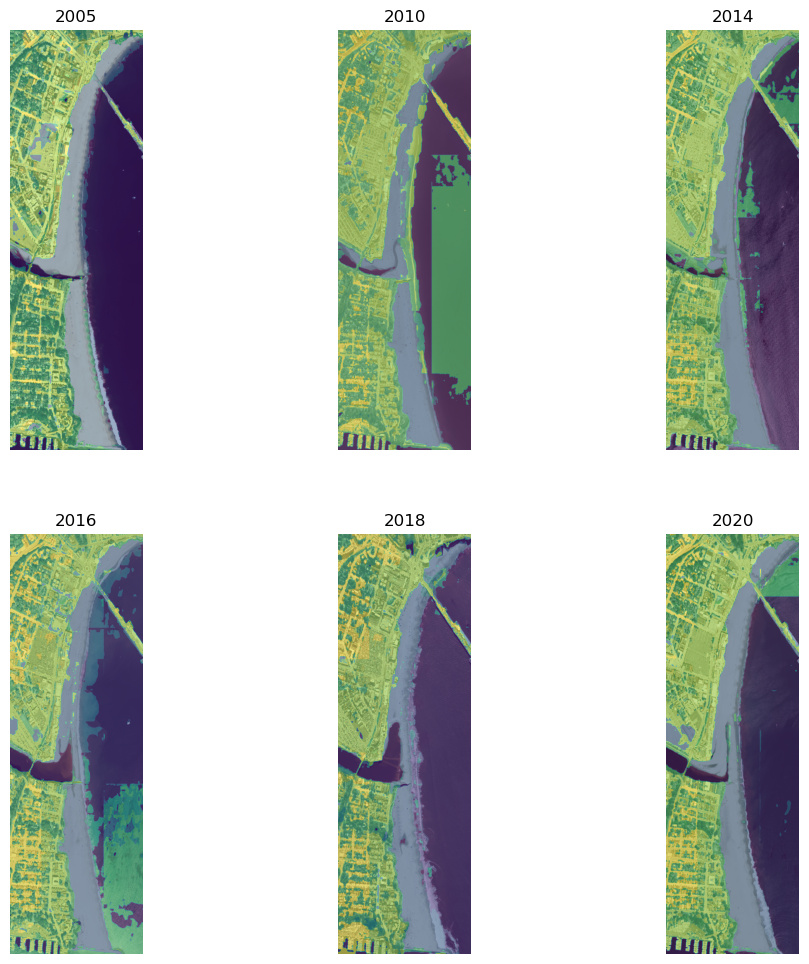

In [61]:
%matplotlib inline
f, axs = plt.subplots(2,3, figsize=(12,12))

axs[0][0].imshow(im_show.sel(time='2005').squeeze().transpose()/255.)
axs[0][0].imshow(geotiffs_ds.sel(time='2005').to_array().squeeze().transpose(), alpha=0.5)
axs[0][0].axis('off'); axs[0][0].set_title('2005')

axs[0][1].imshow(im_show.sel(time='2010').squeeze().transpose()/255.)
axs[0][1].imshow(geotiffs_ds.sel(time='2010').to_array().squeeze().transpose(), alpha=0.5)
axs[0][1].axis('off'); axs[0][1].set_title('2010')

axs[0][2].imshow(im_show.sel(time='2014').squeeze().transpose()/255.)
axs[0][2].imshow(geotiffs_ds.sel(time='2014').to_array().squeeze().transpose(), alpha=0.5)
axs[0][2].axis('off'); axs[0][2].set_title('2014')

axs[1][0].imshow(im_show.sel(time='2016').squeeze().transpose()/255.)
axs[1][0].imshow(geotiffs_ds.sel(time='2016').to_array().squeeze().transpose(), alpha=0.5)
axs[1][0].axis('off'); axs[1][0].set_title('2016')

axs[1][1].imshow(im_show.sel(time='2018').squeeze().transpose()/255.)
axs[1][1].imshow(geotiffs_ds.sel(time='2018').to_array().squeeze().transpose(), alpha=0.5)
axs[1][1].axis('off'); axs[1][1].set_title('2018')

axs[1][2].imshow(im_show.sel(time='2020').squeeze().transpose()/255.)
axs[1][2].imshow(geotiffs_ds.sel(time='2020').to_array().squeeze().transpose(), alpha=0.5)
axs[1][2].axis('off'); axs[1][2].set_title('2020')

#### Part 4: show sand maps

Text(0.5, 1.0, '2020')

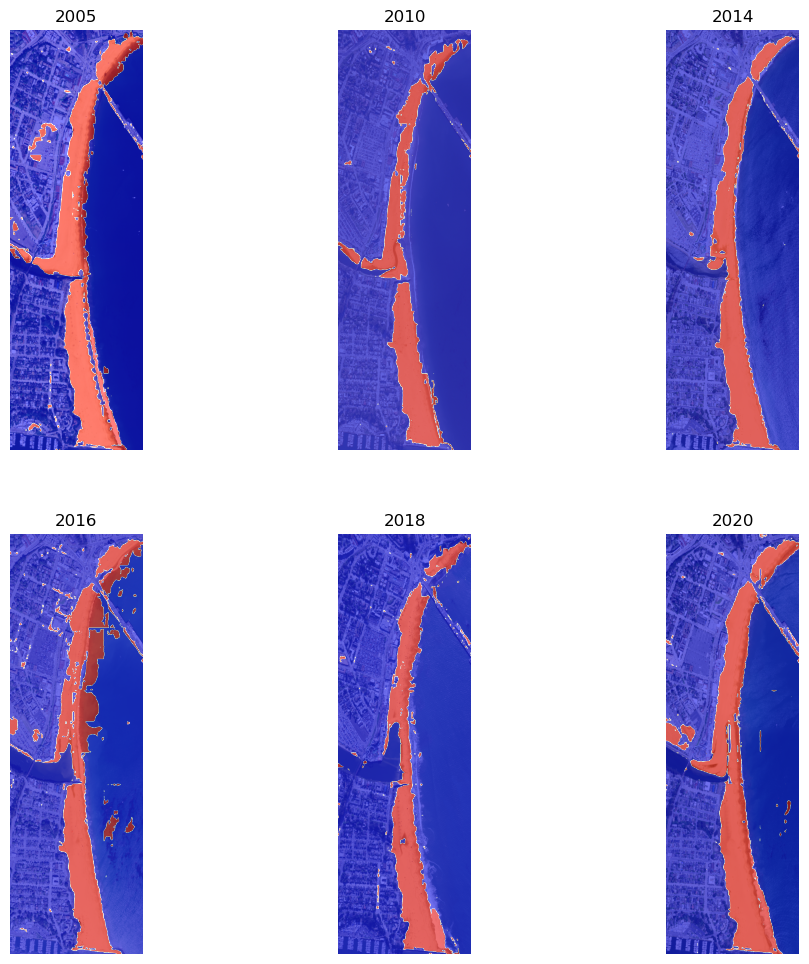

In [63]:
%matplotlib inline
f, axs = plt.subplots(2,3, figsize=(12,12))

axs[0][0].imshow(im_show.sel(time='2005').squeeze().transpose()/255.)
axs[0][0].imshow(geotiffs_ds.sel(time='2005').to_array().squeeze().transpose()==3, alpha=0.5, cmap='bwr')
axs[0][0].axis('off'); axs[0][0].set_title('2005')

axs[0][1].imshow(im_show.sel(time='2010').squeeze().transpose()/255.)
axs[0][1].imshow(geotiffs_ds.sel(time='2010').to_array().squeeze().transpose()==3, alpha=0.5, cmap='bwr')
axs[0][1].axis('off'); axs[0][1].set_title('2010')

axs[0][2].imshow(im_show.sel(time='2014').squeeze().transpose()/255.)
axs[0][2].imshow(geotiffs_ds.sel(time='2014').to_array().squeeze().transpose()==3, alpha=0.5, cmap='bwr')
axs[0][2].axis('off'); axs[0][2].set_title('2014')

axs[1][0].imshow(im_show.sel(time='2016').squeeze().transpose()/255.)
axs[1][0].imshow(geotiffs_ds.sel(time='2016').to_array().squeeze().transpose()==3, alpha=0.5, cmap='bwr')
axs[1][0].axis('off'); axs[1][0].set_title('2016')

axs[1][1].imshow(im_show.sel(time='2018').squeeze().transpose()/255.)
axs[1][1].imshow(geotiffs_ds.sel(time='2018').to_array().squeeze().transpose()==3, alpha=0.5, cmap='bwr')
axs[1][1].axis('off'); axs[1][1].set_title('2018')

axs[1][2].imshow(im_show.sel(time='2020').squeeze().transpose()/255.)
axs[1][2].imshow(geotiffs_ds.sel(time='2020').to_array().squeeze().transpose()==3, alpha=0.5, cmap='bwr')
axs[1][2].axis('off'); axs[1][2].set_title('2020')

#### Part 5: compute and show some time-averaged variables

In [81]:
mean_image = im_geotiffs_ds.mean("time", skipna=True)

In [82]:
stdev_label = geotiffs_ds.std("time", skipna=True)
stdev_label.rio.to_raster(raster_path=f"{site}/label_time_stdev.tif", dtype=dtype)

mean_label = geotiffs_ds.mean("time", skipna=True)
mean_label.rio.to_raster(raster_path=f"{site}/label_time_mean.tif", dtype=dtype)

Text(0.5, 1.0, 'Stdev. label')

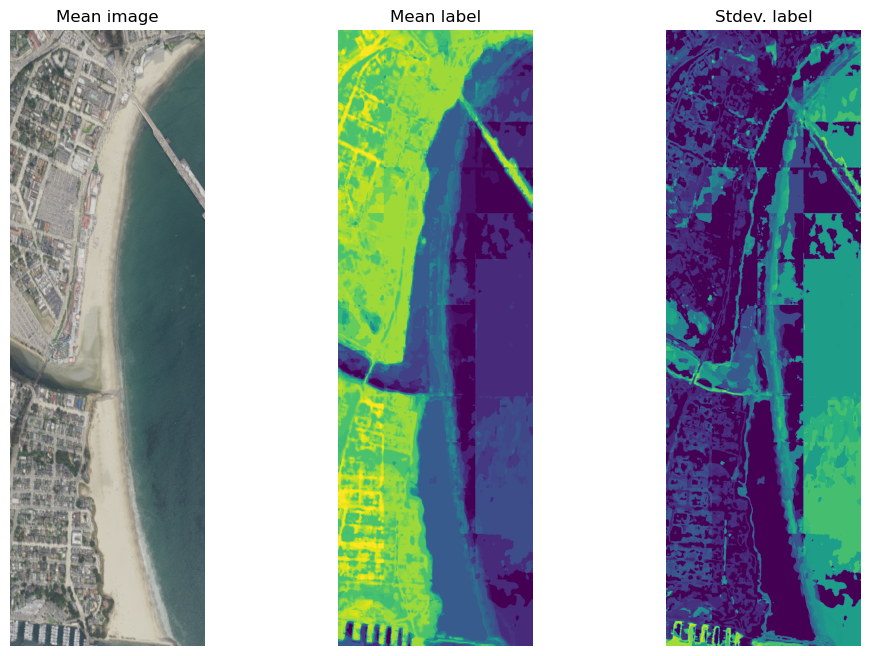

In [85]:
%matplotlib inline
f, axs = plt.subplots(1, 3, figsize=(12,8))

axs[0].imshow(mean_image.to_array().squeeze().transpose()/255.)
axs[0].axis('off'); axs[0].set_title('Mean image')

axs[1].imshow(mean_label.to_array().squeeze().transpose())
axs[1].axis('off'); axs[1].set_title('Mean label')

axs[2].imshow(stdev_label.to_array().squeeze().transpose())
axs[2].axis('off'); axs[2].set_title('Stdev. label')


Text(0.5, 1.0, 'Time-average sand')

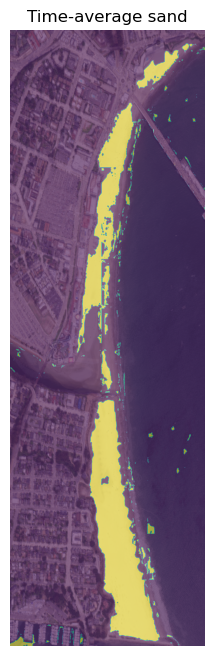

In [87]:
%matplotlib inline
f, axs = plt.subplots(1, 1, figsize=(12,8))

axs.imshow(mean_image.to_array().squeeze().transpose()/255.)
axs.imshow(mean_label.to_array().squeeze().transpose()==3, alpha=0.5)
axs.axis('off'); axs.set_title('Time-average sand')

In [88]:
mosaic_files = [f'{site}/Mosaic{year}_Prob2.tif' for year in years]
mosaic_files = sorted(mosaic_files)
print(mosaic_files)

# Load in and concatenate all individual GeoTIFFs
geotiffs_da = xr.concat([rioxarray.open_rasterio(i, chunks=chunksize, dtype=dtype) for i in mosaic_files],
                        dim=time_var)
# Covert our xarray.DataArray into a xarray.Dataset
geotiffs_ds = geotiffs_da.to_dataset('band')

# Rename the variable to a more useful name
geotiffs_ds = geotiffs_ds.rename({1: 'sand_probs'})

geotiffs_ds

['beaches/Mosaic2005_Prob2.tif', 'beaches/Mosaic2010_Prob2.tif', 'beaches/Mosaic2014_Prob2.tif', 'beaches/Mosaic2016_Prob2.tif', 'beaches/Mosaic2018_Prob2.tif', 'beaches/Mosaic2020_Prob2.tif']


<xarray.Dataset>
Dimensions:      (time: 6, y: 1635, x: 5165)
Coordinates:
  * x            (x) float64 -122.0 -122.0 -122.0 ... -122.0 -122.0 -122.0
  * y            (y) float64 36.97 36.97 36.97 36.97 ... 36.96 36.96 36.96 36.96
    spatial_ref  int64 0
  * time         (time) <U4 '2005' '2010' '2014' '2016' '2018' '2020'
Data variables:
    sand_probs   (time, y, x) float32 dask.array<chunksize=(1, 1635, 5165), meta=np.ndarray>
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0.0
    scale_factor:   1.0
    add_offset:     0.0

In [89]:
mean_sand_prob = geotiffs_ds.mean("time", skipna=True)
mean_sand_prob.rio.to_raster(raster_path=f"{site}/sand_prob_time_mean.tif", dtype=dtype)

Text(0.5, 1.0, 'Time-average sand (threshold=0.6)')

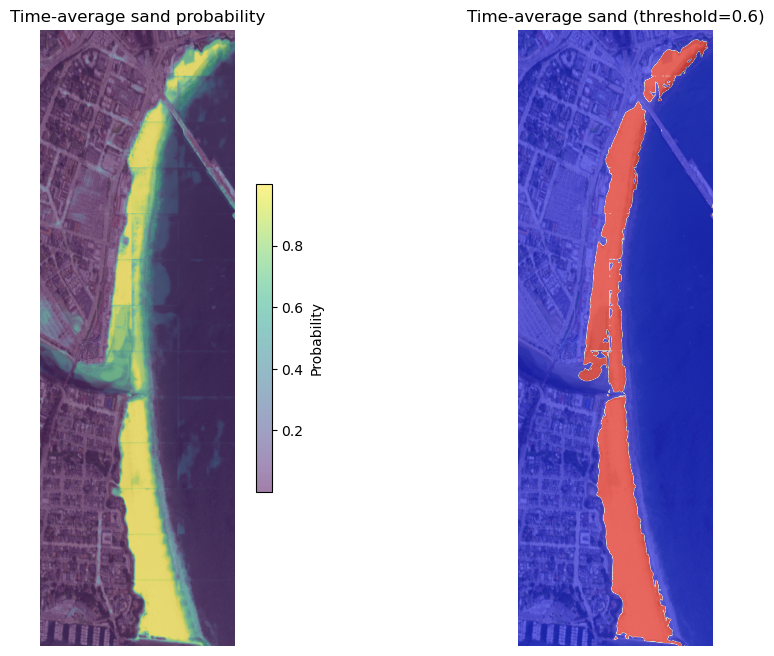

In [92]:
%matplotlib inline
f, axs = plt.subplots(1, 2, figsize=(12,8))

axs[0].imshow(mean_image.to_array().squeeze().transpose()/255.)
im = axs[0].imshow(mean_sand_prob.to_array().squeeze().transpose(), alpha=0.5)
axs[0].axis('off'); axs[0].set_title('Time-average sand probability')
cb = plt.colorbar(im, shrink=0.5)
cb.set_label('Probability')

axs[1].imshow(mean_image.to_array().squeeze().transpose()/255.)
im = axs[1].imshow(mean_sand_prob.to_array().squeeze().transpose()>.6, alpha=0.5, cmap='bwr')
axs[1].axis('off'); axs[1].set_title('Time-average sand (threshold=0.6)')

Text(0.5, 1.0, '2020')

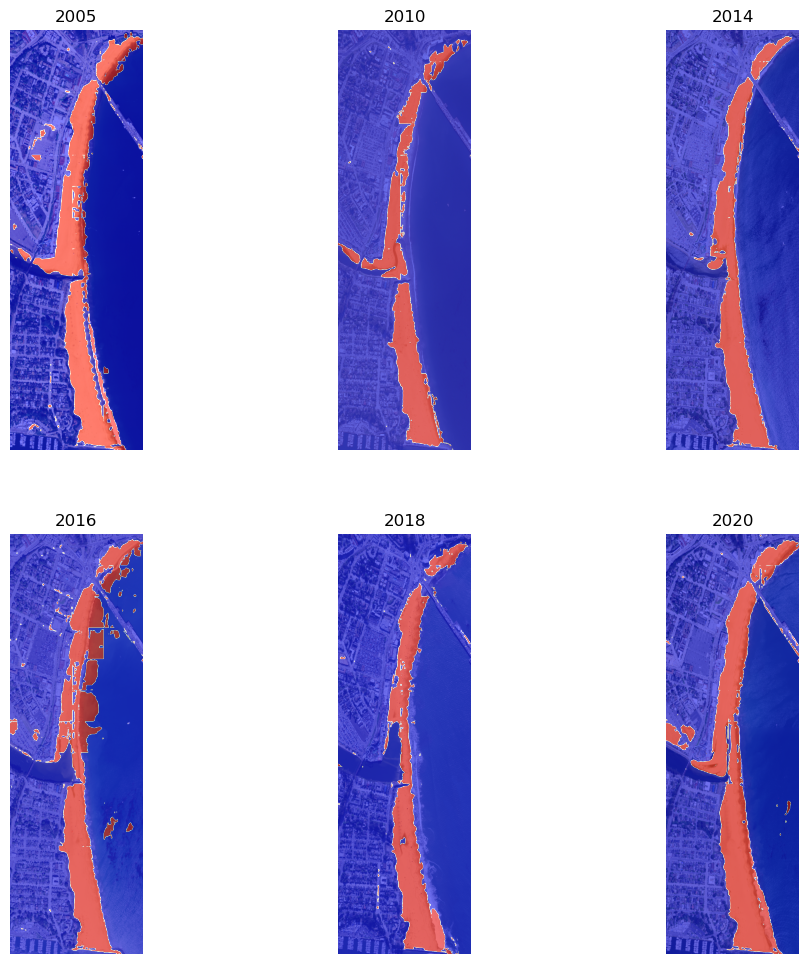

In [93]:
%matplotlib inline
f, axs = plt.subplots(2,3, figsize=(12,12))

axs[0][0].imshow(im_show.sel(time='2005').squeeze().transpose()/255.)
axs[0][0].imshow(geotiffs_ds.sel(time='2005').to_array().squeeze().transpose()>.6, alpha=0.5, cmap='bwr')
axs[0][0].axis('off'); axs[0][0].set_title('2005')

axs[0][1].imshow(im_show.sel(time='2010').squeeze().transpose()/255.)
axs[0][1].imshow(geotiffs_ds.sel(time='2010').to_array().squeeze().transpose()>.6, alpha=0.5, cmap='bwr')
axs[0][1].axis('off'); axs[0][1].set_title('2010')

axs[0][2].imshow(im_show.sel(time='2014').squeeze().transpose()/255.)
axs[0][2].imshow(geotiffs_ds.sel(time='2014').to_array().squeeze().transpose()>.6, alpha=0.5, cmap='bwr')
axs[0][2].axis('off'); axs[0][2].set_title('2014')

axs[1][0].imshow(im_show.sel(time='2016').squeeze().transpose()/255.)
axs[1][0].imshow(geotiffs_ds.sel(time='2016').to_array().squeeze().transpose()>.6, alpha=0.5, cmap='bwr')
axs[1][0].axis('off'); axs[1][0].set_title('2016')

axs[1][1].imshow(im_show.sel(time='2018').squeeze().transpose()/255.)
axs[1][1].imshow(geotiffs_ds.sel(time='2018').to_array().squeeze().transpose()>.6, alpha=0.5, cmap='bwr')
axs[1][1].axis('off'); axs[1][1].set_title('2018')

axs[1][2].imshow(im_show.sel(time='2020').squeeze().transpose()/255.)
axs[1][2].imshow(geotiffs_ds.sel(time='2020').to_array().squeeze().transpose()>.6, alpha=0.5, cmap='bwr')
axs[1][2].axis('off'); axs[1][2].set_title('2020')

#### Part 6: compute and show some time-series of mapped sand

4.0


Text(0.5, 0, 'Year')

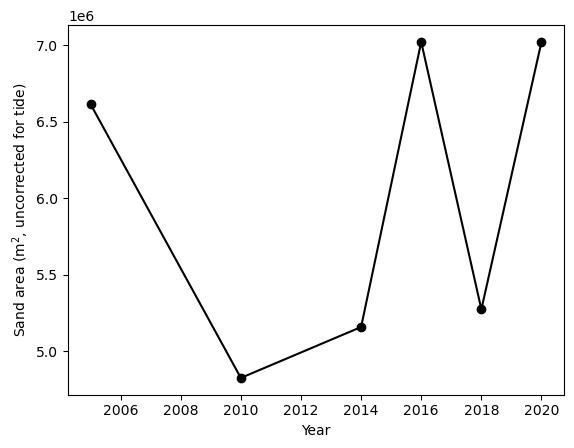

In [223]:
px2sqm = (1/OUT_RES_M)**2
print(px2sqm)

sums = np.array([float(geotiffs_ds.sand_probs.sel(time=year).sum().compute()) for year in years])
dt = [datetime.strptime(year,'%Y') for year in years]

plt.plot(dt, sums*px2sqm, 'k-o')
plt.ylabel(r'Sand area (m$^2$), uncorrected for tide')
plt.xlabel('Year')

In [255]:
def nan_indexer(y):
    """downloads best model from zenodo.

    Args:
        files (list): list of available files for zenodo release
        model_direc (str): directory of model to download

    Raises:
        FileNotFoundError: if model filename in 'BEST_MODEL.txt' does not
        exist online
    """       
    return np.isnan(y), lambda z: z.nonzero()[0]

def get_shoreline(im):
    """downloads best model from zenodo.

    Args:
        files (list): list of available files for zenodo release
        model_direc (str): directory of model to download

    Raises:
        FileNotFoundError: if model filename in 'BEST_MODEL.txt' does not
        exist online
    """       
    s=[]
    for k in range(im.shape[0]):
        # x = np.convolve(im[k,:], np.ones(N)/N, mode='valid')
        tmp = np.where(im[k,:]>0)[0]
        if len(tmp)<1:
            tmp = np.nan
        else:
            tmp = tmp[-1]
            if np.any(np.gradient(tmp))>5:
                tmp = np.nan
        s.append(tmp)

    ## basic iterative outlier detection
    s = np.array(s)
    for k in range(5):
        s[s>(np.nanmean(s)+2*np.nanstd(s))] = np.nan
        s[s<(np.nanmean(s)-2*np.nanstd(s))] = np.nan

        nans, x= nan_indexer(s)
        s[nans]= np.interp(x(nans), x(~nans), s[~nans])
    return s

Next, we'll find the shoreline contour for each image. We start with a probability map, that is binarized (converted into 0s and 1s)

apply a morphological operation to eac

In [284]:
se = disk(16) 
thres_prob = 0.5 

In [285]:
im = (geotiffs_ds.sel(time='2005').to_array().squeeze().transpose()>thres_prob).to_numpy().astype('int')
#gets rid of small mis-classified blobs of sand
ime = binary_erosion(im, se) 
s2005 = get_shoreline(ime)

Text(0.5, 1.0, 'Filtered sand')

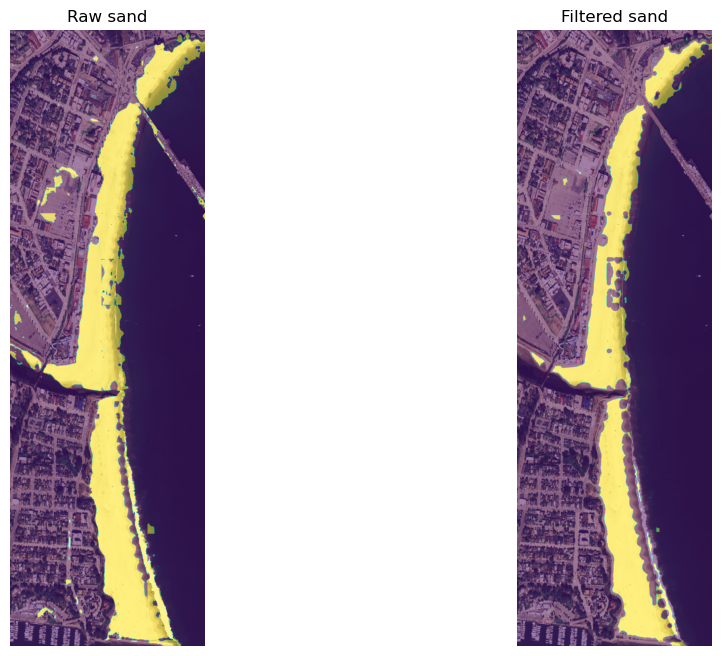

In [286]:
%matplotlib inline
f, axs = plt.subplots(1, 2, figsize=(12,8))

axs[0].imshow(im_show.sel(time='2005').squeeze().transpose()/255.)
im = axs[0].imshow(im, alpha=0.5)
axs[0].axis('off'); axs[0].set_title('Raw sand')

axs[1].imshow(im_show.sel(time='2005').squeeze().transpose()/255.)
im = axs[1].imshow(ime, alpha=0.5)
axs[1].axis('off'); axs[1].set_title('Filtered sand')

In [287]:

im = (geotiffs_ds.sel(time='2010').to_array().squeeze().transpose()>.6).to_numpy().astype('int')
ime = binary_erosion(im, se)  
s2010 = get_shoreline(ime)

im = (geotiffs_ds.sel(time='2014').to_array().squeeze().transpose()>.6).to_numpy().astype('int')
ime = binary_erosion(im, se) 
s2014 = get_shoreline(ime)

im = (geotiffs_ds.sel(time='2016').to_array().squeeze().transpose()>.6).to_numpy().astype('int')
ime = binary_erosion(im, se) 
s2016 = get_shoreline(ime)

im = (geotiffs_ds.sel(time='2018').to_array().squeeze().transpose()>.6).to_numpy().astype('int')
ime = binary_erosion(im, se) 
s2018 = get_shoreline(ime)

im = (geotiffs_ds.sel(time='2020').to_array().squeeze().transpose()>.6).to_numpy().astype('int')
ime = binary_erosion(im, se) 
s2020 = get_shoreline(ime)

Text(0.5, 1.0, 'Filtered sand')

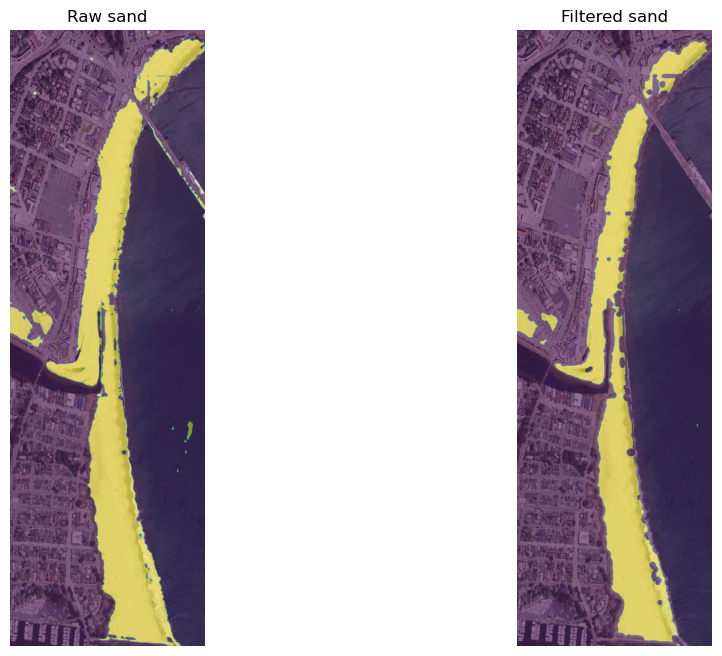

In [289]:
%matplotlib inline
f, axs = plt.subplots(1, 2, figsize=(12,8))

axs[0].imshow(im_show.sel(time='2020').squeeze().transpose()/255.)
im = axs[0].imshow(im, alpha=0.5)
axs[0].axis('off'); axs[0].set_title('Raw sand')

axs[1].imshow(im_show.sel(time='2020').squeeze().transpose()/255.)
im = axs[1].imshow(ime, alpha=0.5)
axs[1].axis('off'); axs[1].set_title('Filtered sand')

Text(0.5, 1.0, '2020')

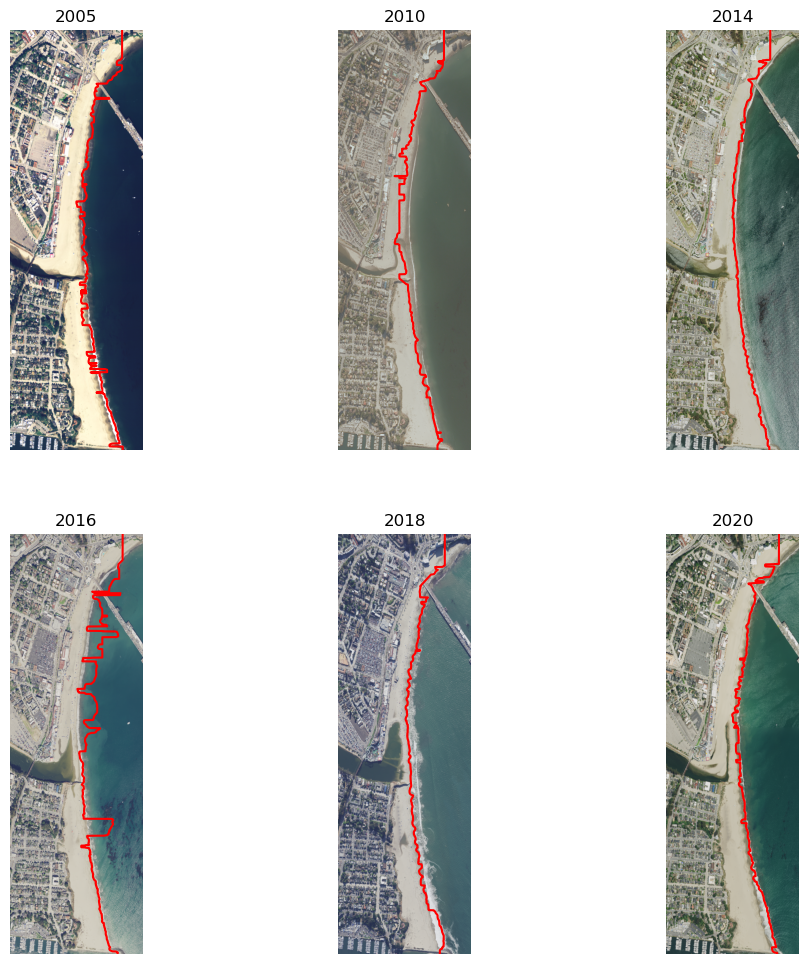

In [290]:
%matplotlib inline
f, axs = plt.subplots(2,3, figsize=(12,12))

axs[0][0].imshow(im_show.sel(time='2005').squeeze().transpose()/255.)
axs[0][0].plot(s2005,np.arange(len(s)),'r')
axs[0][0].axis('off'); axs[0][0].set_title('2005')

axs[0][1].imshow(im_show.sel(time='2010').squeeze().transpose()/255.)
axs[0][1].plot(s2010,np.arange(len(s)),'r')
axs[0][1].axis('off'); axs[0][1].set_title('2010')

axs[0][2].imshow(im_show.sel(time='2014').squeeze().transpose()/255.)
axs[0][2].plot(s2014,np.arange(len(s)),'r')
axs[0][2].axis('off'); axs[0][2].set_title('2014')

axs[1][0].imshow(im_show.sel(time='2016').squeeze().transpose()/255.)
axs[1][0].plot(s2016,np.arange(len(s)),'r')
axs[1][0].axis('off'); axs[1][0].set_title('2016')

axs[1][1].imshow(im_show.sel(time='2018').squeeze().transpose()/255.)
axs[1][1].plot(s2018,np.arange(len(s)),'r')
axs[1][1].axis('off'); axs[1][1].set_title('2018')

axs[1][2].imshow(im_show.sel(time='2020').squeeze().transpose()/255.)
axs[1][2].plot(s2020,np.arange(len(s)),'r')
axs[1][2].axis('off'); axs[1][2].set_title('2020')

(-0.5, 1634.5, 5164.5, -0.5)

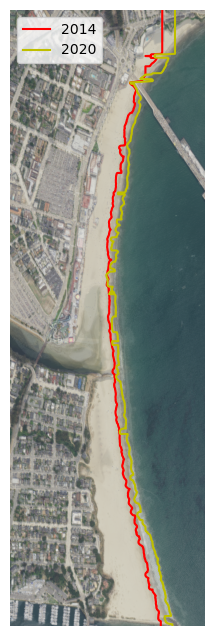

In [291]:
%matplotlib inline
f, axs = plt.subplots(1, 1, figsize=(12,8))

axs.imshow(mean_image.to_array().squeeze().transpose()/255.)
axs.plot(s2014,np.arange(len(s2014)),'r', label='2014')
axs.plot(s2020,np.arange(len(s2020)),'y', label='2020')
plt.legend()
plt.axis('off')

## Discussion

better results with an ensemble of models, test-tiume aug, etc

implementation choices are important, too!

Model input grids

Check model outputs

New generation of real-time data assimilation models?


## Conclusions

This is a *very* stripped-down version of the [Seg2Map](https://github.com/Doodleverse/seg2map) toolbox, through which is is possible to download an imag time-series and apply numerous models for image segmentation. See the [project wiki](https://github.com/Doodleverse/seg2map/wiki) for more details. Similar functionality is also available for orthomosaic imagery, using [this script](https://github.com/Doodleverse/segmentation_zoo/blob/main/scripts/segment_orthomosaic.py) in the Segmentation Zoo repository. Note that the Doodleverse is an ongoing community project - if you're interested in helping out, send us a note on Github!


## Acknowledgements

Jon Warrick, Chris Sherwood, and the rest of the USGS Remote Sensing Coastal Change (RSCC) project members,

Cameron Bodine, CSDMS crew!


## References

* Buscombe, D., & Goldstein, E. B. (2022). A reproducible and reusable pipeline for segmentation of geoscientific imagery. *Earth and Space Science*, 9, e2022EA002332. https://doi.org/10.1029/2022EA002332
* Buscombe, D., Goldstein, E. B., Sherwood, C. R., Bodine, C., Brown, J. A., Favela, J., et al. (2022). Human-in-the-loop segmentation of Earth surface imagery. *Earth and Space Science*, 9, e2021EA002085. https://doi.org/10.1029/2021EA002085
* Buscombe, D., Wernette, P., Fitzpatrick, S., Favela, J., Goldstein, E.B. and Enwright, N.M., 2023. A 1.2 Billion Pixel Human-Labeled Dataset for Data-Driven Classification of Coastal Environments. *Scientific Data*, 10(1), p.46.
* Buscombe, Daniel. (2023). Doodleverse/Segmentation Zoo/Seg2Map Res-UNet models for CoastTrain/8-class segmentation of RGB 768x768 NAIP images (v1.0) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.7570583
* Xie, E., Wang, W., Yu, Z., Anandkumar, A., Alvarez, J.M. and Luo, P., 2021. SegFormer: Simple and efficient design for semantic segmentation with transformers. *Advances in Neural Information Processing Systems*, 34, pp.12077-12090.